In [1]:
!pip install pomegranate

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from pgmpy.estimators import PC
# from pgmpy.models import BayesianNetwork
from pomegranate import BayesianNetwork
from sklearn.model_selection import train_test_split

In [3]:
covid_policies_df = pd.read_csv(
    "../Final_Data_Combined.csv", index_col=0
)
print(covid_policies_df.shape)
covid_policies_df.head()

(11993, 19)


,Country,Date,school_closures,workplace_closures,cancel_public_events,restrict_public_gathering,closure_public_transport,SHN_requirement,restriction_internal_movement,internation_travel_control,PI_Campaign,testing_policy,contact_tracing,Facial_Covering,Vaccine_policy,income_support,debt_relief,Confirmed_cases,Confirmed_Deathes
0,Argentina,2020-05-02,3G,3T,2G,4G,2G,2G,1G,4.0,2G,1.0,2.0,3G,0,1A,2.0,4681.0,237.0
1,Argentina,2020-05-03,3G,3T,2G,4G,2G,2G,1G,4.0,2G,1.0,2.0,3G,0,1A,2.0,4783.0,246.0
2,Argentina,2020-05-04,3G,3T,2G,4G,2G,2G,1G,4.0,2G,1.0,2.0,3G,0,1A,2.0,4887.0,260.0
3,Argentina,2020-05-05,3G,3T,2G,4G,2G,2G,1G,4.0,2G,1.0,2.0,3G,0,1A,2.0,5020.0,264.0
4,Argentina,2020-05-06,3G,3T,2G,4G,2G,2G,1G,4.0,2G,1.0,2.0,3G,0,1A,2.0,5208.0,273.0


#### Preprocessing

In [4]:
covid_policies_df["date"] = pd.to_datetime(covid_policies_df["Date"])
covid_policies_df["Country"] = covid_policies_df["Country"].str.lower()
covid_policies_df["Country"] = covid_policies_df["Country"].str.replace(" ", "_")
covid_policies_df.rename(columns={"Country": "country"}, inplace=True)
covid_policies_df.set_index(["country", "date"], inplace=True)
covid_policies_df.drop(columns=["Date"], inplace=True)
covid_policies_df.rename(
    columns={col: col.lower() for col in covid_policies_df.columns}, inplace=True
)
print(covid_policies_df.shape)
covid_policies_df.head()

(11993, 17)


school_closures workplace_closures cancel_public_events  \
country   date                                                                 
argentina 2020-05-02              3G                 3T                   2G   
          2020-05-03              3G                 3T                   2G   
          2020-05-04              3G                 3T                   2G   
          2020-05-05              3G                 3T                   2G   
          2020-05-06              3G                 3T                   2G   

                     restrict_public_gathering closure_public_transport  \
country   date                                                            
argentina 2020-05-02                        4G                       2G   
          2020-05-03                        4G                       2G   
          2020-05-04                        4G                       2G   
          2020-05-05                        4G                       2G   
          2020-05-06                        4G                       2G   

                     shn_requirement restriction_internal_movement  \
country   date                                                       
argentina 2020-05-02              2G                            1G   
          2020-05-03              2G                            1G   
          2020-05-04              2G                            1G   
          2020-05-05              2G                            1G   
          2020-05-06              2G                            1G   

                      internation_travel_control pi_campaign  testing_policy  \
country   date                                                                 
argentina 2020-05-02                         4.0          2G             1.0   
          2020-05-03                         4.0          2G             1.0   
          2020-05-04                         4.0          2G             1.0   
          2020-05-05                         4.0          2G             1.0   
          2020-05-06                         4.0          2G             1.0   

                      contact_tracing facial_covering vaccine_policy  \
country   date                                                         
argentina 2020-05-02              2.0              3G              0   
          2020-05-03              2.0              3G              0   
          2020-05-04              2.0              3G              0   
          2020-05-05              2.0              3G              0   
          2020-05-06              2.0              3G              0   

                     income_support  debt_relief  confirmed_cases  \
country   date                                                      
argentina 2020-05-02             1A          2.0           4681.0   
          2020-05-03             1A          2.0           4783.0   
          2020-05-04             1A          2.0           4887.0   
          2020-05-05             1A          2.0           5020.0   
          2020-05-06             1A          2.0           5208.0   

                      confirmed_deathes  
country   date                           
argentina 2020-05-02              237.0  
          2020-05-03              246.0  
          2020-05-04              260.0  
          2020-05-05              264.0  
          2020-05-06              273.0

In [5]:
for column in covid_policies_df.columns:
    if pd.api.types.is_numeric_dtype(covid_policies_df[column].dtype):
        continue

    covid_policies_df[column] = (
        covid_policies_df[column].apply(lambda v: v[:1]).astype("int16")
    )

display(covid_policies_df.info())
covid_policies_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11993 entries, ('argentina', Timestamp('2020-05-02 00:00:00')) to ('south_africa', Timestamp('2022-02-27 00:00:00'))
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   school_closures                11993 non-null  int16  
 1   workplace_closures             11993 non-null  int16  
 2   cancel_public_events           11993 non-null  int16  
 3   restrict_public_gathering      11993 non-null  int16  
 4   closure_public_transport       11993 non-null  int16  
 5   shn_requirement                11993 non-null  int16  
 6   restriction_internal_movement  11993 non-null  int16  
 7   internation_travel_control     11993 non-null  float64
 8   pi_campaign                    11993 non-null  int16  
 9   testing_policy                 11993 non-null  float64
 10  contact_tracing                11993 non-null  float64
 11  facial_covering

None

school_closures  workplace_closures  \
country   date                                              
argentina 2020-05-02                3                   3   
          2020-05-03                3                   3   
          2020-05-04                3                   3   
          2020-05-05                3                   3   
          2020-05-06                3                   3   

                      cancel_public_events  restrict_public_gathering  \
country   date                                                          
argentina 2020-05-02                     2                          4   
          2020-05-03                     2                          4   
          2020-05-04                     2                          4   
          2020-05-05                     2                          4   
          2020-05-06                     2                          4   

                      closure_public_transport  shn_requirement  \
country   date                                                    
argentina 2020-05-02                         2                2   
          2020-05-03                         2                2   
          2020-05-04                         2                2   
          2020-05-05                         2                2   
          2020-05-06                         2                2   

                      restriction_internal_movement  \
country   date                                        
argentina 2020-05-02                              1   
          2020-05-03                              1   
          2020-05-04                              1   
          2020-05-05                              1   
          2020-05-06                              1   

                      internation_travel_control  pi_campaign  testing_policy  \
country   date                                                                  
argentina 2020-05-02                         4.0            2             1.0   
          2020-05-03                         4.0            2             1.0   
          2020-05-04                         4.0            2             1.0   
          2020-05-05                         4.0            2             1.0   
          2020-05-06                         4.0            2             1.0   

                      contact_tracing  facial_covering  vaccine_policy  \
country   date                                                           
argentina 2020-05-02              2.0                3               0   
          2020-05-03              2.0                3               0   
          2020-05-04              2.0                3               0   
          2020-05-05              2.0                3               0   
          2020-05-06              2.0                3               0   

                      income_support  debt_relief  confirmed_cases  \
country   date                                                       
argentina 2020-05-02               1          2.0           4681.0   
          2020-05-03               1          2.0           4783.0   
          2020-05-04               1          2.0           4887.0   
          2020-05-05               1          2.0           5020.0   
          2020-05-06               1          2.0           5208.0   

                      confirmed_deathes  
country   date                           
argentina 2020-05-02              237.0  
          2020-05-03              246.0  
          2020-05-04              260.0  
          2020-05-05              264.0  
          2020-05-06              273.0

In [6]:
countries = list(covid_policies_df.reset_index()["country"].unique())
countries

['argentina',
 'australia',
 'brazil',
 'canada',
 'switzerland',
 'china',
 'germany',
 'egypt',
 'finland',
 'hong_kong',
 'indonesia',
 'india',
 'israel',
 'malaysia',
 'new_zealand',
 'singapore',
 'united_states',
 'south_africa']

In [7]:
country_to_population_map = { # for 2021
    "argentina": 45.85e6,
    "australia": 25750198,
    "brazil": 212.61e6,
    "canada": 37.74e6,
    "switzerland": 8.66e6,
    "germany": 83900473,
    "egypt": 101.48e6,
    "finland": 5.54e6,
    "india": 1.39e9,
    "united_states": 332915073,
    "new_zealand": 5122600,
    "south_africa": 60e6,
    "hong_kong": 7500000,
    "china": 1448000000,
    "indonesia": 272000000,
    "singapore": 5450000,
    "malaysia": 32000000,
    "israel": 9.45e6
}

In [8]:
def compute_cases_bin(cases_per_mil):
    computed_bin = None
    if cases_per_mil <= 10000:
        computed_bin = 0
    elif cases_per_mil < 30000:
        computed_bin = 1
    elif cases_per_mil < 50000:
        computed_bin = 2
    elif cases_per_mil < 70000:
        computed_bin = 3
    elif cases_per_mil < 100000:
        computed_bin = 4
    elif cases_per_mil < 120000:
        computed_bin = 5
    else:
        computed_bin = 6

    return computed_bin

covid_policies_df["cases_per_mil"] = covid_policies_df.apply(lambda row: (row.confirmed_cases * 1000000)/ country_to_population_map[row.name[0]], axis=1)
covid_policies_df["cases_per_mil_cat"] = covid_policies_df["cases_per_mil"].apply(compute_cases_bin)
print(covid_policies_df.shape)
covid_policies_df.head()

(11993, 19)


school_closures  workplace_closures  \
country   date                                              
argentina 2020-05-02                3                   3   
          2020-05-03                3                   3   
          2020-05-04                3                   3   
          2020-05-05                3                   3   
          2020-05-06                3                   3   

                      cancel_public_events  restrict_public_gathering  \
country   date                                                          
argentina 2020-05-02                     2                          4   
          2020-05-03                     2                          4   
          2020-05-04                     2                          4   
          2020-05-05                     2                          4   
          2020-05-06                     2                          4   

                      closure_public_transport  shn_requirement  \
country   date                                                    
argentina 2020-05-02                         2                2   
          2020-05-03                         2                2   
          2020-05-04                         2                2   
          2020-05-05                         2                2   
          2020-05-06                         2                2   

                      restriction_internal_movement  \
country   date                                        
argentina 2020-05-02                              1   
          2020-05-03                              1   
          2020-05-04                              1   
          2020-05-05                              1   
          2020-05-06                              1   

                      internation_travel_control  pi_campaign  testing_policy  \
country   date                                                                  
argentina 2020-05-02                         4.0            2             1.0   
          2020-05-03                         4.0            2             1.0   
          2020-05-04                         4.0            2             1.0   
          2020-05-05                         4.0            2             1.0   
          2020-05-06                         4.0            2             1.0   

                      contact_tracing  facial_covering  vaccine_policy  \
country   date                                                           
argentina 2020-05-02              2.0                3               0   
          2020-05-03              2.0                3               0   
          2020-05-04              2.0                3               0   
          2020-05-05              2.0                3               0   
          2020-05-06              2.0                3               0   

                      income_support  debt_relief  confirmed_cases  \
country   date                                                       
argentina 2020-05-02               1          2.0           4681.0   
          2020-05-03               1          2.0           4783.0   
          2020-05-04               1          2.0           4887.0   
          2020-05-05               1          2.0           5020.0   
          2020-05-06               1          2.0           5208.0   

                      confirmed_deathes  cases_per_mil  cases_per_mil_cat  
country   date                                                             
argentina 2020-05-02              237.0     102.093784                  0  
          2020-05-03              246.0     104.318430                  0  
          2020-05-04              260.0     106.586696                  0  
          2020-05-05              264.0     109.487459                  0  
          2020-05-06              273.0     113.587786                  0

In [9]:
covid_policies_df = covid_policies_df.reset_index()

In [10]:
covid_policies_df.head()

,country,date,school_closures,workplace_closures,cancel_public_events,restrict_public_gathering,closure_public_transport,shn_requirement,restriction_internal_movement,internation_travel_control,...,testing_policy,contact_tracing,facial_covering,vaccine_policy,income_support,debt_relief,confirmed_cases,confirmed_deathes,cases_per_mil,cases_per_mil_cat
0,argentina,2020-05-02,3,3,2,4,2,2,1,4.0,...,1.0,2.0,3,0,1,2.0,4681.0,237.0,102.093784,0
1,argentina,2020-05-03,3,3,2,4,2,2,1,4.0,...,1.0,2.0,3,0,1,2.0,4783.0,246.0,104.318430,0
2,argentina,2020-05-04,3,3,2,4,2,2,1,4.0,...,1.0,2.0,3,0,1,2.0,4887.0,260.0,106.586696,0
3,argentina,2020-05-05,3,3,2,4,2,2,1,4.0,...,1.0,2.0,3,0,1,2.0,5020.0,264.0,109.487459,0
4,argentina,2020-05-06,3,3,2,4,2,2,1,4.0,...,1.0,2.0,3,0,1,2.0,5208.0,273.0,113.587786,0


In [11]:
for c in covid_policies_df.country.unique():
    exec(f"df_{c} = covid_policies_df[covid_policies_df.country == \"{c}\"]")
    eval(f"print(\"Size of df_{c}\",df_{c}.shape)")

Size of df_argentina (661, 21)
Size of df_australia (667, 21)
Size of df_brazil (667, 21)
Size of df_canada (667, 21)
Size of df_switzerland (667, 21)
Size of df_china (667, 21)
Size of df_germany (667, 21)
Size of df_egypt (667, 21)
Size of df_finland (667, 21)
Size of df_hong_kong (666, 21)
Size of df_indonesia (667, 21)
Size of df_india (667, 21)
Size of df_israel (667, 21)
Size of df_malaysia (661, 21)
Size of df_new_zealand (667, 21)
Size of df_singapore (667, 21)
Size of df_united_states (667, 21)
Size of df_south_africa (667, 21)


In [12]:
for c in covid_policies_df.country.unique():
  exec(f"df_{c} = df_{c}.add_suffix('_{c}')")

In [13]:
# removing duplicate rows for same date (take max restriction for the specific date)
# df_china = df_china.groupby("date_China").max().reset_index()

In [14]:
m4 = df_china
for c in covid_policies_df.country.unique():
  if c != "china":
    # china already assigned
    exec(f"m4 = pd.merge(m4, df_{c}, left_on='date_china', right_on='date_{c}')")
    print(m4.shape)


(661, 42)
(661, 63)
(661, 84)
(661, 105)
(661, 126)
(661, 147)
(661, 168)
(661, 189)
(660, 210)
(660, 231)
(660, 252)
(660, 273)
(660, 294)
(660, 315)
(660, 336)
(660, 357)
(660, 378)


In [15]:
len(m4.columns)

378

In [16]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [17]:
m4.rename(columns={"date_china": "date"}, inplace=True)

In [18]:
columns_to_drop = m4.filter(regex="^country_|^date_|^confirmed_cases_").columns

In [19]:
new_df = m4.drop(columns_to_drop, axis = 1)

In [20]:
new_df.shape

(660, 325)

#### Train - Test Split

In [21]:
y_cols = list(new_df.filter(regex="^cases_per_mil_cat_").columns)
x_cols = list(set(new_df.columns) - set(y_cols))
print(len(x_cols))
print(len(y_cols))

307
18


In [22]:
x_train, x_test, y_train, y_test = train_test_split(
    new_df[x_cols], new_df[y_cols]
)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(495, 307)
(165, 307)
(495, 18)
(165, 18)


In [23]:
train = pd.concat([x_train, y_train], axis = 1)
print(train.shape)

(495, 325)


In [24]:
test = pd.concat([x_test, y_test], axis = 1)
print(test.shape)

(165, 325)


#### Structure Learning

In [25]:
import seaborn, time
seaborn.set_style('whitegrid')
est = BayesianNetwork.from_samples(train, algorithm='chow-liu')

In [26]:
print(est.structure)

((), (0,), (0,), (10,), (161,), (245,), (212,), (245,), (0,), (193,), (0,), (126,), (108,), (0,), (10,), (108,), (133,), (63,), (147,), (245,), (147,), (108,), (34,), (0,), (99,), (193,), (242,), (0,), (218,), (133,), (0,), (133,), (0,), (108,), (10,), (0,), (0,), (147,), (0,), (248,), (0,), (193,), (3,), (147,), (10,), (119,), (0,), (0,), (99,), (0,), (126,), (193,), (218,), (287,), (0,), (0,), (3,), (42,), (141,), (133,), (245,), (0,), (108,), (10,), (0,), (0,), (108,), (0,), (10,), (99,), (10,), (161,), (119,), (218,), (108,), (133,), (0,), (3,), (193,), (10,), (99,), (218,), (0,), (133,), (0,), (0,), (0,), (147,), (99,), (108,), (0,), (301,), (161,), (267,), (99,), (119,), (126,), (119,), (235,), (10,), (253,), (193,), (0,), (0,), (0,), (212,), (0,), (141,), (135,), (10,), (147,), (228,), (119,), (108,), (228,), (0,), (193,), (147,), (0,), (135,), (276,), (267,), (133,), (0,), (0,), (0,), (183,), (212,), (0,), (126,), (0,), (193,), (0,), (10,), (0,), (10,), (212,), (79,), (265,), (

In [27]:
import pickle
with open('bayesian_18countries_estmodel_pomegranate_structure.pkl', 'wb') as handle:
    pickle.dump(est.structure, handle)

In [28]:
import matplotlib
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


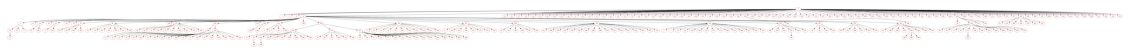

In [30]:
plt.figure(figsize=(20, 20))
est.plot()
plt.show()

In [30]:
# est = PC(data=train)
# estimated_model = est.estimate(variant="parallel", max_cond_vars=4) # can change the max_cond_vars value

In [31]:
# est_dict = est.to_dict()

In [32]:
# import pickle
# with open('bayesian_18countries_estimated_model_pomegranate.pkl', 'wb') as handle:
#     pickle.dump(est.to_dict(), handle)

#### Parameter Estimation

In [33]:
import pickle
with open(r"bayesian_18countries_estmodel_pomegranate_structure.pkl", "rb") as input_file:
  struct = pickle.load(input_file)

In [34]:
estimated_model = BayesianNetwork.from_structure(X=train, structure=struct)

#### Inferencing

In [35]:
test.iloc[0]

school_closures_israel                            2
cases_per_mil_egypt                     3289.712259
restrict_public_gathering_australia               4
internation_travel_control_argentina            2.0
restriction_internal_movement_brazil              2
                                           ...     
cases_per_mil_cat_malaysia                        4
cases_per_mil_cat_new_zealand                     0
cases_per_mil_cat_singapore                       2
cases_per_mil_cat_united_states                   6
cases_per_mil_cat_south_africa                    2
Name: 549, Length: 325, dtype: object

In [36]:
estimated_model.predict([([None] * (train.shape[1]- 3)) + [1, 5, 1]])

[array([1, 2704.020496649586, 4, 4.0, 2, 2, 44401.75206163617, 3, 3.0, 1,
        2, 4, 2, 600480.0, 3.0, 2, 1, 2, 2.0, 2.0, 3, 0, 0, 1, 2, 4, 2,
        2.0, 1.0, 2, 2, 2.0, 1, 1.0, 4, 2.0, 26466.0, 1, 80518.70669745958,
        2, 1.0, 2, 1, 3, 2, 3, 1, 2, 4, 2, 3, 3.0, 4, 4, 2.0, 2, 2, 4.0,
        2.0, 4, 1, 2, 523.5622535431227, 1, 3.0, 1.0, 910.0, 4, 3, 5, 1, 1,
        0, 2, 100911.88932139458, 2, 3.0, 1.0, 2, 2, 88844.97354497355, 2,
        3.0, 1, 2, 2, 3.0, 1, 980.0, 0, 6418.0, 0, 0.0, 1, 1.0, 3.0, 0.0,
        4636.0, 1, 3.0, 2, 4, 2, 2, 0, 2.0, 2.0, 3, 1.0, 2, 496427.0, 2,
        3.0, 3, 10712.0, 2, 3, 4.0, 1, 2, 2, 16984.476534296027, 1, 0, 2,
        2.0, 1.0, 3.0, 0, 20871.125, 2, 3, 0, 1, 3.0, 2, 2, 1, 3, 1, 2, 1,
        2, 2.0, 2, 90277.0, 1.0, 2, 2, 7087.161764705882, 1, 1, 3.0, 3, 3,
        4, 2, 2, 0, 3.0, 26.0, 5, 0, 3.0, Timestamp('2021-06-15 00:00:00'),
        37336.433492315846, 2, 2, 2, 1, 1.0, 0, 0, 11433.944954128441,
        56363.0, 2, 2, 3, 4.0, 1, 0,